# State of the Problem 1: EFFECTS OF METEOROLOGICAL FACTORS TO DENGUE CASES

## PYTHON TOOLS NEEDED

In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt

## SEIR MODEL

In [3]:
# 1. Model with Meteorological Factors
def seir_sei_meteo(y, t, beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m, temp, rain, humidity):
    Sh, Eh, Ih, Rh, Sm, Em, Im = y

    # Ensure t is an integer for array indexing
    t_index = int(t)
    
    # Check if the index is within the array bounds to prevent errors
    if t_index >= len(temp):
        t_index = len(temp) - 1

    temp_scaled = (temp[t_index] - np.mean(temp)) / np.std(temp)
    rain_scaled = (rain[t_index] - np.mean(rain)) / np.std(rain)
    humid_scaled = (humidity[t_index] - np.mean(humidity)) / np.std(humidity)

    beta_h = beta_hv * (1 + 0.05 * temp_scaled + 0.05 * rain_scaled + 0.05 * humid_scaled)
    beta_m = beta_vh * (1 + 0.05 * temp_scaled + 0.05 * rain_scaled + 0.05 * humid_scaled)

    # Total populations
    N_h = Sh + Eh + Ih + Rh
    N_m = Sm + Em + Im
    
    # Human (SEIR) equations
    dShdt = mu_h * N_h - beta_h * Sh * Im / N_h - mu_h * Sh
    dEhdt = (beta_h * Sh * Im / N_h) - (sigma_h + mu_h) * Eh
    dIhdt = (sigma_h * Eh) - (gamma_h + mu_h) * Ih
    dRhdt = (gamma_h * Ih) - (mu_h * Rh)

    # Vector (SEI) equations
    dSmdt = A - beta_m * Sm * Ih / N_h - mu_m * Sm
    dEmdt = (beta_m * Sm * Ih / N_h) - (sigma_m + mu_m) * Em
    dImdt = (sigma_m * Em) - mu_m * Im

    return [dShdt, dEhdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [4]:
# 2. Model without Meteorological Factors
def seir_sei_model(y, t, beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m):
    Sh, Eh, Ih, Rh, Sm, Em, Im = y

    # Total populations
    N_h = Sh + Eh + Ih + Rh
    N_m = Sm + Em + Im
    
    # Human (SEIR) equations
    dShdt = mu_h * N_h - beta_hv * Sh * Im / N_h - mu_h * Sh
    dEhdt = (beta_hv * Sh * Im / N_h) - (sigma_h + mu_h) * Eh
    dIhdt = (sigma_h * Eh) - (gamma_h + mu_h) * Ih
    dRhdt = (gamma_h * Ih) - (mu_h * Rh)

    # Vector (SEI) equations
    dSmdt = A - beta_vh * Sm * Ih / N_h - mu_m * Sm
    dEmdt = (beta_vh * Sm * Ih / N_h) - (sigma_m + mu_m) * Em
    dImdt = (sigma_m * Em) - mu_m * Im

    return [dShdt, dEhdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

## SIMULATION AND EVALUATION

In [5]:
dengue_cases = pd.read_csv('2023_cases_x_larvae.csv')

beta_hv = 1/12       # Human-to-vector transmission rate
sigma_h = 1/5       # Human incubation period (5 days)
gamma_h = 1/10      # Human infectious period (10 days)
mu_h = 1/(70*365)   # Human life expectancy (70 years)
A = 0.445            # Mosquito recruitment rate
mu_m = 1/14         # Mosquito lifespan (14 days)
beta_vh = 1/12       # Vector-to-human transmission rate
sigma_m = 1/10      # Mosquito incubation period (10 days)

# human cases primary value
N_h =  dengue_cases['Total_Population'].iloc[-1]
I_h0 = dengue_cases['New_cases'].iloc[-1]
E_h0 = 0
R_h0 = dengue_cases['Total_cases'].iloc[-1]
S_h0 = N_h - I_h0 - E_h0 - R_h0

# mosquito primnary value
N_m = dengue_cases['Total_Mosquito_Population'].iloc[-1]
I_m0 = dengue_cases['Total_Mosquito_Population'].iloc[-1] * A
E_m0 = 0
S_m0 = N_m - I_m0 - E_m0

y0 = [S_h0, E_h0, I_h0, R_h0, S_m0, E_m0, I_m0]


# Time array for a 90-day simulation
time_array = np.arange(0, 365)

# --- MODIFIED: Generate a full year's worth of meteorological data ---
# Query all available monthly data for the year
all_monthly_data = dengue_cases.groupby('Month_Num').agg({
    'TMEAN': 'mean',
    'RAINFALL': 'mean',
    'RH': 'mean'
}).reset_index()

# Extract monthly averages and standard deviations
monthly_ave_temp = all_monthly_data['TMEAN'].values
monthly_ave_rain = all_monthly_data['RAINFALL'].values
monthly_ave_humidity = all_monthly_data['RH'].values

temp_std = np.std(dengue_cases['TMEAN'])
rain_std = np.std(dengue_cases['RAINFALL'])
humidity_std = np.std(dengue_cases['RH'])

# Reset daily lists
temp_daily = []
rain_daily = []
humidity_daily = []

# Assuming 30 or 31 days per month
days_in_each_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
if len(monthly_ave_temp) < 12:
    print("Warning: Insufficient monthly data. Generating placeholder data for missing months.")
    # Pad the monthly averages with zeros or other values if you don't have a full year
    monthly_ave_temp = np.pad(monthly_ave_temp, (0, 12 - len(monthly_ave_temp)), 'constant', constant_values=0)
    monthly_ave_rain = np.pad(monthly_ave_rain, (0, 12 - len(monthly_ave_rain)), 'constant', constant_values=0)
    monthly_ave_humidity = np.pad(monthly_ave_humidity, (0, 12 - len(monthly_ave_humidity)), 'constant', constant_values=0)
    

for i in range(len(monthly_ave_temp)):
    days = days_in_each_month[i]
    temps = np.random.normal(monthly_ave_temp[i], temp_std, days)
    rains = np.random.normal(monthly_ave_rain[i], rain_std, days)
    humids = np.random.normal(monthly_ave_humidity[i], humidity_std, days)

    rains = np.clip(rains, 0, None)
    humids = np.clip(humids, 0, 100)

    temp_daily.extend(temps)
    rain_daily.extend(rains)
    humidity_daily.extend(humids)

# Ensure all lists have 365 items to match the time_array
temp_daily = temp_daily[:365]
rain_daily = rain_daily[:365]
humidity_daily = humidity_daily[:365]


### Simulation 1: SEIR forecast with Meteorological Data

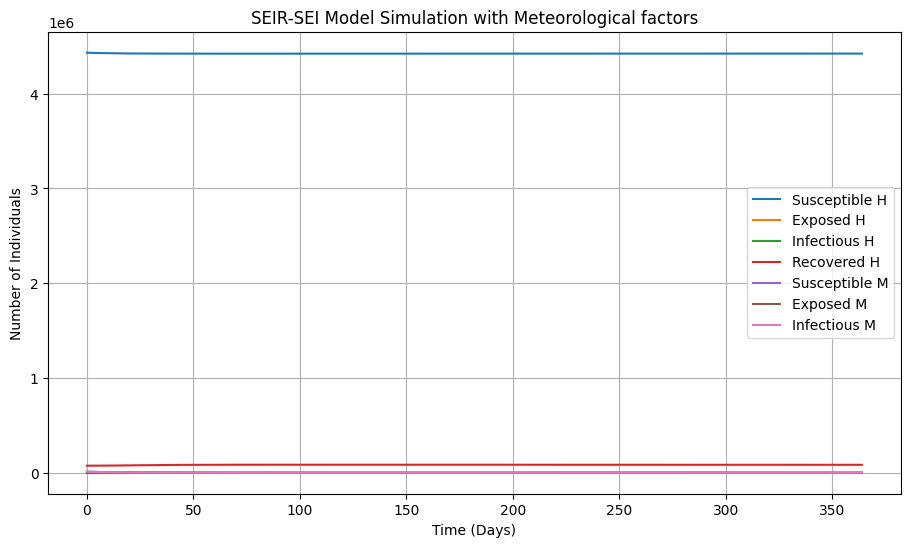

In [6]:
solution_meteo = odeint(seir_sei_meteo, y0, time_array, args=(beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m, temp_daily, rain_daily, humidity_daily))
simulated_cases_meteo = solution_meteo[:, 2] # Index 2 is the 'I' (Infected) compartment

Sh, Eh, Ih, Rh, Sm, Em, Im = solution_meteo.T # Transpose the solution to get S, E, I, R, S, E, I as separate arrays

# --- Plot the Results ---
plt.figure(figsize=(11, 6))
plt.plot(time_array, Sh, label='Susceptible H')
plt.plot(time_array, Eh, label='Exposed H')
plt.plot(time_array, Ih, label='Infectious H')
plt.plot(time_array, Rh, label='Recovered H')
plt.plot(time_array, Sm, label='Susceptible M')
plt.plot(time_array, Em, label='Exposed M')
plt.plot(time_array, Im, label='Infectious M')
plt.xlabel('Time (Days)')
plt.ylabel('Number of Individuals')
plt.title('SEIR-SEI Model Simulation with Meteorological factors')
plt.legend()
plt.grid(True)
plt.show()

### Simulation 2: Standard SEIR forecast 

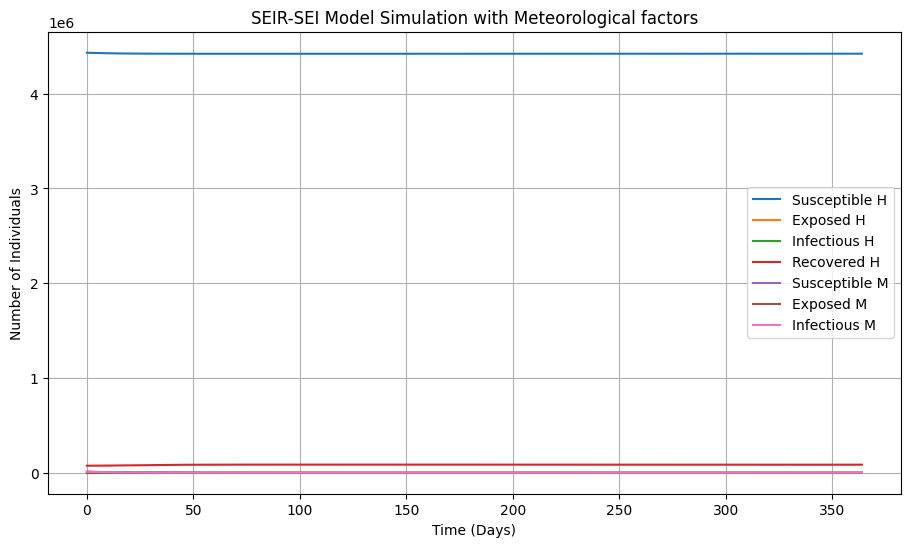

In [7]:
solution = odeint(seir_sei_model, y0, time_array, args=(beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m))
simulated_cases_no_meteo = solution[:, 2] # Index 2 is the 'I' (Infected) compartment

Sh, Eh, Ih, Rh, Sm, Em, Im = solution.T # Transpose the solution to get S, E, I, R, S, E, I as separate arrays

SEIR_SEI = pd.DataFrame({
    'Sh': Sh,
    'Eh': Eh,
    'Ih': Ih,
    'Rh': Rh,
    'Sm': Sm,
    'Em': Em,
    'Im': Im
})

SEIR_SEI.to_csv('SEIR-SEI.csv', mode='w', index=False)


# --- Plot the Results ---
plt.figure(figsize=(11, 6))
plt.plot(time_array, Sh, label='Susceptible H')
plt.plot(time_array, Eh, label='Exposed H')
plt.plot(time_array, Ih, label='Infectious H')
plt.plot(time_array, Rh, label='Recovered H')
plt.plot(time_array, Sm, label='Susceptible M')
plt.plot(time_array, Em, label='Exposed M')
plt.plot(time_array, Im, label='Infectious M')
plt.xlabel('Time (Days)')
plt.ylabel('Number of Individuals')
plt.title('SEIR-SEI Model Simulation with Meteorological factors')
plt.legend()
plt.grid(True)
plt.show()

## STATISTICAL ANALYSIS AND COMPARISON

In [8]:
# Observed data for the past 12 months
dc = pd.read_csv('cleaned_dengue_data.csv')
recent_observed_cases = dc['New_cases'].tail(len(monthly_ave_temp)).values

# Function to evaluate model accuracy
def evaluate_model(y_true, y_pred):
    """Calculates RMSE and R-squared."""
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r_squared = r2_score(y_true, y_pred)
    return rmse, r_squared

# -------------------- DATA AGGREGATION --------------------
# Aggregate the daily simulated data into monthly totals
# This reshapes the 365-day array into 12 months (with 30 or 31 days) and sums each month
def aggregate_daily_to_monthly(daily_data, days_in_month=30):
    """Converts a daily array to a monthly sum array."""
    num_months = len(daily_data) // days_in_month
    aggregated_data = np.array([
        np.sum(daily_data[i*days_in_month:(i+1)*days_in_month]) 
        for i in range(num_months)
    ])
    return aggregated_data

# Perform the aggregation for both models
simulated_meteo_monthly = aggregate_daily_to_monthly(simulated_cases_meteo)
simulated_no_meteo_monthly = aggregate_daily_to_monthly(simulated_cases_no_meteo)

# Ensure the aggregated data has the same length as the observed data (12)
simulated_meteo_monthly = simulated_meteo_monthly[:12]
simulated_no_meteo_monthly = simulated_no_meteo_monthly[:12]

# -------------------- Model Evaluation --------------------
# Evaluate the model with meteorological factors
rmse_meteo, r2_meteo = evaluate_model(recent_observed_cases, simulated_meteo_monthly)
print("Model WITH Meteorological Factors:")
print(f"  RMSE: {rmse_meteo:.2f}")
print(f"  R-squared: {r2_meteo:.2f}")

print("-" * 30)

# Evaluate the model without meteorological factors
rmse_no_meteo, r2_no_meteo = evaluate_model(recent_observed_cases, simulated_no_meteo_monthly)
print("Model WITHOUT Meteorological Factors:")
print(f"  RMSE: {rmse_no_meteo:.2f}")
print(f"  R-squared: {r2_no_meteo:.2f}")

print("-" * 30)

# -------------------- SOP 1: Conclusion --------------------
if rmse_meteo < rmse_no_meteo and r2_meteo > r2_no_meteo:
    print("Conclusion: Including meteorological factors IMPROVES forecast accuracy.")
    print("The factors have a significant effect on dengue transmission.")
else:
    print("Conclusion: Including meteorological factors does NOT improve forecast accuracy.")
    print("The factors may not have a significant effect, or the model's formulation needs adjustment.")

Model WITH Meteorological Factors:
  RMSE: 21583.68
  R-squared: -16464.05
------------------------------
Model WITHOUT Meteorological Factors:
  RMSE: 23802.62
  R-squared: -20023.50
------------------------------
Conclusion: Including meteorological factors IMPROVES forecast accuracy.
The factors have a significant effect on dengue transmission.
